--- INICIO DEL PROCESAMIENTO AUTOMATIZADO ---
Datos de campo (16): [32, 34, 24, 40, 36, 40, 35, 32, 34, 37, 35, 40, 35, 38, 41, 43]
Ángulo de disparo: 90°

--- FASE 2: FILTRO ESTADÍSTICO ---
Promedio Inicial: 36.00
Rango permitido: [30.00  a  42.00]
Valores descartables: [24 43]
Cantidad de descartes: 2

--- FASE 3: VERIFICACIÓN DE VALIDEZ ---
🟢 VALIDACIÓN EXITOSA: El ensayo procede.

                 CONCLUSIÓN DEL ENSAYO
⚠️ No se consideran los valores 24 y 43, porque están más alejados de la desviación estándar.
El promedio del índice de rebote es 36.36, es decir, 234.52 kg/cm².

Datos Técnicos Adicionales:
- Calidad Estadística: BUENA (CV=8.33%)
- Resistencia en PSI : 3335.76 psi


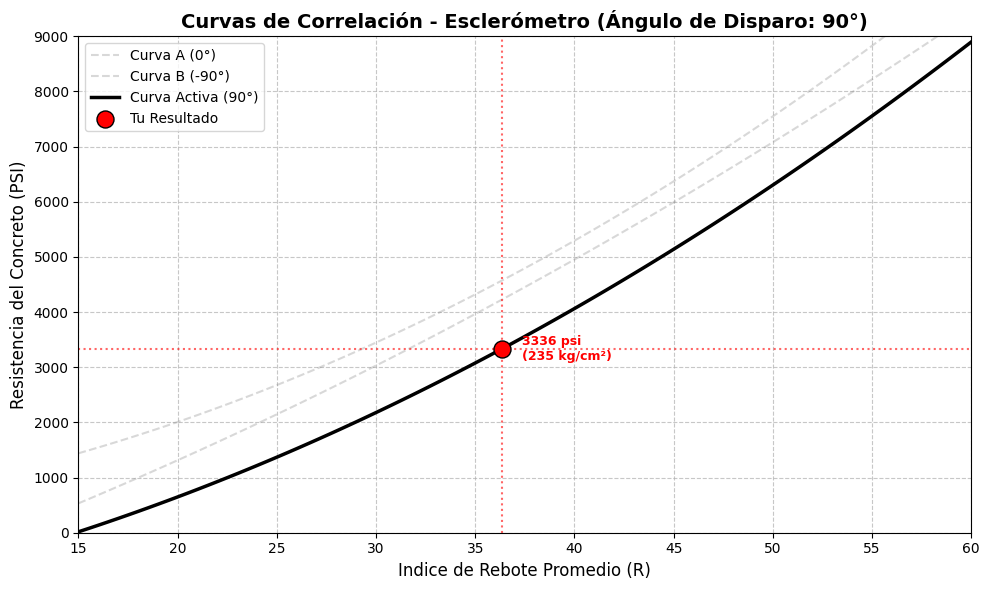

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==============================================================================
# 📌 INPUT: DATOS DE CAMPO (MODIFICAR AQUÍ)
# ==============================================================================
# Ingresa aquí tus 16 mediciones registradas en la matriz 4x4
lecturas_crudas = [32, 34, 24, 40, 
36, 40, 35, 32, 
34, 37, 35, 40,
35, 38, 41, 43]

# Ángulo de disparo: 
#   0   = Horizontal (Peralte de vigas/Columnas)
#  -90  = Vertical Hacia Abajo (Losas/Pisos)
#   90  = Vertical Hacia Arriba (Techos/Fondos de viga)
angulo = 90 

print(f"--- INICIO DEL PROCESAMIENTO AUTOMATIZADO ---")
print(f"Datos de campo ({len(lecturas_crudas)}): {lecturas_crudas}")
print(f"Ángulo de disparo: {angulo}°")

# ==============================================================================
# 📌 FASE 1: PREPARACIÓN DE DATOS
# ==============================================================================
# Trabajamos directamente con los valores leídos
R_analisis = np.array(lecturas_crudas)

# ==============================================================================
# 📌 FASE 2: FILTRADO NORMATIVO ( NTP 339.181)
# ==============================================================================
promedio_inicial = np.mean(R_analisis)
limite_superior = promedio_inicial + 6
limite_inferior = promedio_inicial - 6

print(f"\n--- FASE 2: FILTRO ESTADÍSTICO ---")
print(f"Promedio Inicial: {promedio_inicial:.2f}")
print(f"Rango permitido: [{limite_inferior:.2f}  a  {limite_superior:.2f}]")

# Detección de outliers
indices_descartes = np.where((R_analisis > limite_superior) | (R_analisis < limite_inferior))
valores_descartados = R_analisis[indices_descartes]
cantidad_descartes = len(valores_descartados)

print(f"Valores descartables: {valores_descartados}")
print(f"Cantidad de descartes: {cantidad_descartes}")

# ==============================================================================
# 📌 FASE 3: VERIFICACIÓN DE LA VALIDEZ DEL ENSAYO
# ==============================================================================
print(f"\n--- FASE 3: VERIFICACIÓN DE VALIDEZ ---")

es_valido = True 

if cantidad_descartes > 2:
    print("🔴 ALERTA CRÍTICA: Se han descartado más de 2 lecturas.")
    print("RESULTADO: EL ENSAYO ES INVÁLIDO. EL CONCRETO ES HETEROGÉNEO.")
    print("ACCIÓN: Descartar todo el set y repetir el ensayo en campo.")
    es_valido = False
else:
    print("🟢 VALIDACIÓN EXITOSA: El ensayo procede.")
    
# ==============================================================================
# BLOQUE DE CÁLCULO (Solo se ejecuta si es válido)
# ==============================================================================
if es_valido:
    
    # --- FASE 4: RECÁLCULO ESTADÍSTICO ---
    # Filtramos: Nos quedamos solo con los datos DENTRO del rango
    R_finales = R_analisis[(R_analisis <= limite_superior) & (R_analisis >= limite_inferior)]
    
    # 1. Promedio Final (Este es el valor 'x' para las curvas)
    promedio_final = np.mean(R_finales)
    
    # 2. Desviación Estándar (Muestra: ddof=1)
    desviacion_estandar = np.std(R_finales, ddof=1)
    
    # 3. Coeficiente de Variación
    cv_porcentaje = (desviacion_estandar / promedio_final) * 100
    
    # --- FASE 5: CLASIFICACIÓN DE CALIDAD ---
    calidad = ""
    if cv_porcentaje < 5:
        calidad = "EXCELENTE"
    elif 5 <= cv_porcentaje < 10:
        calidad = "BUENA"
    elif 10 <= cv_porcentaje < 15:
        calidad = "REGULAR"
    else:
        calidad = "MALA / HETEROGÉNEA"

    # --- FASE 6: CÁLCULO DE RESISTENCIA (f'c) ---
    x = promedio_final 
    f_c_psi = 0
    curva_usada = ""

    # Selección de Ecuación Polinómica según el Ángulo
    if angulo == 0:
        # Curva A (Horizontal)
        f_c_psi = 1.0251 * (x**2) + 120.42 * x - 1504.6
        curva_usada = "A (Horizontal 0°)"
        
    elif angulo == -90:
        # Curva B (Vertical Abajo)
        f_c_psi = 2.0342 * (x**2) + 42.304 * x + 347.72
        curva_usada = "B (Vertical Abajo -90°)"
        
    elif angulo == 90:
        # Curva C (Vertical Arriba)
        f_c_psi = 1.7733 * (x**2) + 64.346 * x - 1347.7
        curva_usada = "C (Vertical Arriba +90°)"
        
    else:
        print("\n⚠️ ALERTA: Ángulo no reconocido. Se usará Curva A por defecto.")
        f_c_psi = 1.0251 * (x**2) + 120.42 * x - 1504.6
        curva_usada = "A (Por defecto)"

    # Conversión de Unidades
    factor_psi_a_kgcm2 = 0.0703057129855624 
    f_c_kgcm2 = f_c_psi * factor_psi_a_kgcm2

    # Validación de resultados negativos
    if f_c_kgcm2 < 0:
        f_c_kgcm2 = 0
        f_c_psi = 0

    # ==============================================================================
    # 📌 REPORTE DE RESPUESTA FINAL (PERSONALIZADO)
    # ==============================================================================
    print("\n" + "="*60)
    print("                 CONCLUSIÓN DEL ENSAYO")
    print("="*60)

    # CASO 1: 0 Descartes
    if cantidad_descartes == 0:
        print("✅ No se realiza ningún descarte, ya que los valores son cercanos a la desviación estándar.")
        print(f"El promedio del índice de rebote es de {promedio_final:.2f}, es decir, {f_c_kgcm2:.2f} kg/cm².")

    # CASO 2: 1 Descarte
    elif cantidad_descartes == 1:
        # Obtenemos el valor eliminado para mostrarlo
        val_elim = valores_descartados[0]
        print(f"⚠️ No se considera el valor {val_elim:.0f} porque está más alejado de la desviación estándar.")
        print(f"El promedio del índice de rebote es de {promedio_final:.2f}, es decir, {f_c_kgcm2:.2f} kg/cm².")

    # CASO 3: 2 Descartes
    elif cantidad_descartes == 2:
        # Obtenemos los dos valores eliminados ordenados
        val_ordenados = np.sort(valores_descartados)
        val1 = val_ordenados[0]
        val2 = val_ordenados[1]
        print(f"⚠️ No se consideran los valores {val1:.0f} y {val2:.0f}, porque están más alejados de la desviación estándar.")
        print(f"El promedio del índice de rebote es {promedio_final:.2f}, es decir, {f_c_kgcm2:.2f} kg/cm².")

    print(f"\nDatos Técnicos Adicionales:")
    print(f"- Calidad Estadística: {calidad} (CV={cv_porcentaje:.2f}%)")
    print(f"- Resistencia en PSI : {f_c_psi:.2f} psi")
    print("="*60)

    # ==============================================================================
    # 📌 FASE 7: VISUALIZACIÓN GRÁFICA
    # ==============================================================================

    # 1. Definir dominio para las curvas
    x_plot = np.linspace(15, 65, 100)

    # 2. Calcular las 3 curvas completas
    y_A = 1.0251 * (x_plot**2) + 120.42 * x_plot - 1504.6
    y_B = 2.0342 * (x_plot**2) + 42.304 * x_plot + 347.72
    y_C = 1.7733 * (x_plot**2) + 64.346 * x_plot - 1347.7

    # 3. Configurar Estilos
    estilo_A = {'color': 'gray', 'alpha': 0.3, 'linewidth': 1.5, 'linestyle': '--', 'label': 'Curva A (0°)'}
    estilo_B = {'color': 'gray', 'alpha': 0.3, 'linewidth': 1.5, 'linestyle': '--', 'label': 'Curva B (-90°)'}
    estilo_C = {'color': 'gray', 'alpha': 0.3, 'linewidth': 1.5, 'linestyle': '--', 'label': 'Curva C (+90°)'}
    estilo_activo = {'color': 'black', 'alpha': 1.0, 'linewidth': 2.5, 'linestyle': '-', 'label': f'Curva Activa ({angulo}°)'}

    if angulo == 0:
        estilo_A = estilo_activo
    elif angulo == -90:
        estilo_B = estilo_activo
    elif angulo == 90:
        estilo_C = estilo_activo
    else:
        estilo_A = estilo_activo

    # 4. Crear el Gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(x_plot, y_A, **estilo_A)
    plt.plot(x_plot, y_B, **estilo_B)
    plt.plot(x_plot, y_C, **estilo_C)

    # 5. Dibujar el PUNTO ROJO
    plt.scatter(promedio_final, f_c_psi, color='red', s=150, zorder=10, edgecolors='black', label='Tu Resultado')
    
    # Líneas guía
    plt.axvline(x=promedio_final, color='red', linestyle=':', alpha=0.6)
    plt.axhline(y=f_c_psi, color='red', linestyle=':', alpha=0.6)
    
    # Texto
    plt.text(promedio_final + 1, f_c_psi, f"{f_c_psi:.0f} psi\n({f_c_kgcm2:.0f} kg/cm²)", 
             fontsize=9, color='red', fontweight='bold', verticalalignment='center')

    # 6. Configuración de Ejes
    plt.title(f"Curvas de Correlación - Esclerómetro (Ángulo de Disparo: {angulo}°)", fontsize=14, fontweight='bold')
    plt.xlabel("Indice de Rebote Promedio (R)", fontsize=12)
    plt.ylabel("Resistencia del Concreto (PSI)", fontsize=12)
    plt.xlim(15, 60)
    plt.ylim(0, 9000) 
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig("Resultado_Esclerometria.pdf", dpi = 500, bbox_inches = "tight")
    plt.show()

else:
    print("\n⚠️ PROCESO DETENIDO: El ensayo no cumple con la norma NTP 339.181 (Más de 2 descartes).")


